In [ ]:
import fitz  # PyMuPDF for text extraction
import spacy
from resume_parser import resumeparse
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import matplotlib.pyplot as plt

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("ahmedheakl/bert-resume-classification")
model = AutoModelForSequenceClassification.from_pretrained("ahmedheakl/bert-resume-classification")
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", revision="d7645e1")


In [2]:
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file using PyMuPDF.
    """
    if not pdf_path.lower().endswith('.pdf'):
        raise ValueError("The provided file is not a PDF.")
    
    with fitz.open(pdf_path) as pdf:
        text = ""
        for page in pdf:
            text += page.get_text()
    return text

def parse_resume(resume_text):
    """
    Extracts information from resume text using spaCy and transformers.
    """
    doc = nlp(resume_text)
    name = None
    skills = []
    education = []
    experience = []

    for ent in doc.ents:
        if ent.label_ == "PERSON" and not name:
            name = ent.text
        elif ent.label_ == "ORG":
            education.append(ent.text)
        elif ent.label_ == "SKILL":
            skills.append(ent.text)
        elif ent.label_ == "WORK_OF_ART":
            experience.append(ent.text)

    tasks = {
        "skills": "The candidate has these skills: {}.",
        "education": "The candidate's educational qualifications include: {}.",
        "experience": "The candidate has experience in: {}."
    }

    for key, value in tasks.items():
        response = classifier(sequences=resume_text, candidate_labels=["skills", "education", "experience"], hypothesis_template=value)
        if key == "skills":
            skills.extend(response['labels'])
        elif key == "education":
            education.extend(response['labels'])
        elif key == "experience":
            experience.extend(response['labels'])

    return name, ", ".join(skills), ", ".join(education), ", ".join(experience)

In [3]:
resumes = ["data/2.pdf", "data/1.pdf"]

ground_truth = pd.DataFrame({
    'name': ['Gwyneth Valerie Brucal', 'Reymel Mislang'],
    'skills': [
        ['Oracle 10g', 'Oracle 11g R1/R2', 'Oracle 12c', 'Data Guard', 'RMAN', 'ASM', 'SQL', 'Backup and Recovery', 
         'Performance Tuning', 'Flashback Mechanism', 'Unix/Linux', 'Sun Solaris', 'Patching', 'Cloning', 'AWR', 
         'ASH', 'ADDM', 'Upgrades', 'Buffer Cache', 'Library Cache', 'Dictionary Cache'],
        ['Database administration', 'MS SQL Server 2005/2008/2012/2014', 'SQL Server', 'Clustering', 'Backups', 
         'T-SQL', 'Virtualization', 'Maintenance', 'Problem-solving', 'SQL Queries', 'Stored Procedures', 'Database Mirroring', 
         'Replication', 'Log Shipping', 'High Availability', 'Disaster Recovery', 'Performance Tuning', 'Capacity Planning']
    ],
    'education': [
        ['Master of Computer Applications (MCA), JNTU - Kakinada, Andhra Pradesh (2013)'],
        ['Bachelor of Science, Lead City University (July 2013)']
    ],
    'experience': [
        ['Oracle Database Administrator - Cognizant, Hyderabad (June 2016 – Present)', 
         'Oracle Database Administrator - Convergys, Hyderabad (June 2014 – June 2016)'],
        ['Database Administrator - Family Private Care LLC, Lawrenceville, GA (April 2017 – Present)', 
         'Database Administrator - Incomm, Alpharetta, GA (January 2014 – February 2017)']
    ]
})

In [4]:
extracted_data = {
    'name': [],
    'skills': [],
    'education': [],
    'experience': []
}

for resume_path in resumes:
    resume_text = extract_text_from_pdf(resume_path)
    name, skills, education, experience = parse_resume(resume_text)
    extracted_data['name'].append(name)
    extracted_data['skills'].append(skills.split(', '))
    extracted_data['education'].append(education.split(', '))
    extracted_data['experience'].append(experience.split(', '))

In [5]:
def clean_labels(label_list):
    cleaned_labels = []
    for labels in label_list:
        if isinstance(labels, list):
            cleaned_sublabels = [label.strip().lower() if label else '' for label in labels]
            cleaned_labels.append(cleaned_sublabels)
        elif isinstance(labels, str):
            cleaned_label = labels.strip().lower() if labels else ''
            cleaned_labels.append(cleaned_label)
    return cleaned_labels

def load_data():
    data = {
            'name': ['Gwyneth Valerie Brucal', 'Reymel Mislang'],
    'skills': [
        ['Oracle 10g', 'Oracle 11g R1/R2', 'Oracle 12c', 'Data Guard', 'RMAN', 'ASM', 'SQL', 'Backup and Recovery', 
         'Performance Tuning', 'Flashback Mechanism', 'Unix/Linux', 'Sun Solaris', 'Patching', 'Cloning', 'AWR', 
         'ASH', 'ADDM', 'Upgrades', 'Buffer Cache', 'Library Cache', 'Dictionary Cache'],
        ['Database administration', 'MS SQL Server 2005/2008/2012/2014', 'SQL Server', 'Clustering', 'Backups', 
         'T-SQL', 'Virtualization', 'Maintenance', 'Problem-solving', 'SQL Queries', 'Stored Procedures', 'Database Mirroring', 
         'Replication', 'Log Shipping', 'High Availability', 'Disaster Recovery', 'Performance Tuning', 'Capacity Planning']
    ],
    'education': [
        ['Master of Computer Applications (MCA), JNTU - Kakinada, Andhra Pradesh (2013)'],
        ['Bachelor of Science, Lead City University (July 2013)']
    ],
    'experience': [
        ['Oracle Database Administrator - Cognizant, Hyderabad (June 2016 – Present)', 
         'Oracle Database Administrator - Convergys, Hyderabad (June 2014 – June 2016)'],
        ['Database Administrator - Family Private Care LLC, Lawrenceville, GA (April 2017 – Present)', 
         'Database Administrator - Incomm, Alpharetta, GA (January 2014 – February 2017)']
    ]}
    return pd.DataFrame(data)

def clean_data(ground_truth):
    ground_truth['name'] = clean_labels(ground_truth['name'])
    ground_truth['skills'] = [clean_labels(skill_list) for skill_list in ground_truth['skills']]
    ground_truth['education'] = [clean_labels(education_list) for education_list in ground_truth['education']]
    ground_truth['experience'] = [clean_labels(experience_list) for experience_list in ground_truth['experience']]
    return ground_truth

c:\Users\ACER\Desktop\trabahanap\env\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['\n', 'D', 'O', 'b'] will be ignored
  warnings.warn(
c:\Users\ACER\Desktop\trabahanap\env\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['education', 'experience', 'skills'] will be ignored
  warnings.warn(
c:\Users\ACER\Desktop\trabahanap\env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ACER\Desktop\trabahanap\env\lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['ASM', 'ASM Instances', 'Additional Information Skills Operating Systems', 'Analysing Instance and System Performance', 'Andhra Pradesh 2013 Skills', 'Assigning Roles and Profiles 

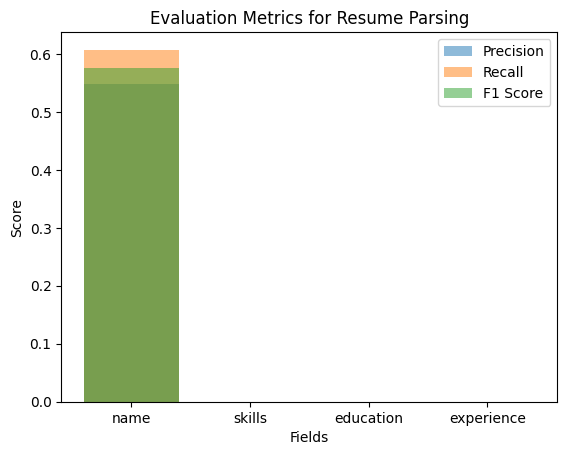

In [6]:
mlb = MultiLabelBinarizer()

precision = {}
recall = {}
f1 = {}

for field in ['name', 'skills', 'education', 'experience']:
    ground_truth_labels = ground_truth[field]
    extracted_labels = extracted_data[field]
    
    if len(ground_truth_labels) != len(extracted_labels):
        raise ValueError(f"Inconsistent number of samples for {field}: {len(ground_truth_labels)} vs {len(extracted_labels)}")

    ground_truth_labels_bin = mlb.fit_transform(ground_truth_labels)
    extracted_labels_bin = mlb.transform(extracted_labels)

    precision[field] = precision_score(ground_truth_labels_bin, extracted_labels_bin, average='micro')
    recall[field] = recall_score(ground_truth_labels_bin, extracted_labels_bin, average='micro')
    f1[field] = f1_score(ground_truth_labels_bin, extracted_labels_bin, average='micro')

# Part 7: Plot Results
fields = ['name', 'skills', 'education', 'experience']

plt.bar(fields, precision.values(), label='Precision', alpha=0.5)
plt.bar(fields, recall.values(), label='Recall', alpha=0.5)
plt.bar(fields, f1.values(), label='F1 Score', alpha=0.5)
plt.xlabel('Fields')
plt.ylabel('Score')
plt.legend()
plt.title('Evaluation Metrics for Resume Parsing')
plt.show()